PENDETEKSIAN KERUSAKAN CAT PADA BAK DUMP TRUK MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK (CNN)

In [1]:
#import libraries and packages

from numpy.random import seed
seed(8) #1

import tensorflow
tensorflow.random.set_seed(7)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

from tensorflow.python.keras import models
from tensorflow.python.keras import layers

from tensorflow.keras import optimizers

In [2]:
# Read the data from folder Dataset
data_dir = '../Dataset'

In [3]:
#print os listdir
print(os.listdir(data_dir))

['Test', 'Train']


In [4]:
#Baca train dataset
print(os.listdir(data_dir + "/Train"))

['Kusam', 'Normal', 'Retak', 'Tergores']


In [5]:
# Pembuatan data generator untuk pra-pemrosesan gambar, data generator ini akan digunakan untuk mempersiapkan data yang akan diberikan ke model.

from os import listdir
import cv2

data_list = listdir(data_dir + "/Train")

print(len(data_list))

#Gray scale and normalization
def convert_and_light_normalization(input_folder_path, output_folder_path):
    for label_folder in os.listdir(input_folder_path):
        label_folder_path = os.path.join(input_folder_path, label_folder)
        output_label_folder_path = os.path.join(output_folder_path, label_folder)
        
        if os.path.isdir(label_folder_path):
            os.makedirs(output_label_folder_path, exist_ok=True)  # Membuat folder output jika belum ada
            
            for image_file in os.listdir(label_folder_path):
                image_path = os.path.join(label_folder_path, image_file)
                
                if image_file.endswith('.jpg') or image_file.endswith('.png') or image_file.endswith('.jpeg'):  # Pastikan hanya membaca file gambar
                    img = cv2.imread(image_path)
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
                    # Normalisasi pencahayaan menggunakan CLAHE (Contrast Limited Adaptive Histogram Equalization)
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                    normalized_img = clahe.apply(gray_img)
                    
                    output_image_path = os.path.join(output_label_folder_path, image_file)
                    cv2.imwrite(output_image_path, normalized_img)

DATASET_PATH = '../Dataset/Train'
output_dir = '../DatasetOut/Train'
test_dir = '../Dataset/Test'

IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 80
LEARNING_RATE =0.0001
convert_and_light_normalization(DATASET_PATH, output_dir)

#Train datagen preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')



# Untuk multiclass menggunakan class_mode = 'categorical'
all_data_batches = train_datagen.flow_from_directory(output_dir,
                                                     target_size=IMAGE_SIZE,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     seed=42,
                                                     class_mode="categorical")

4


Found 26 images belonging to 4 classes.


c:\Users\Imam Maskuri\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\preprocessing\image.py:1451: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


In [6]:
# Kode CNN yang digunakan untuk membangun model berbasis Xception

from tensorflow.keras.applications import Xception
from tensorflow.keras import models, layers, optimizers

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.trainable = True

# Ubah dropout menjadi 0.2 atau sesuai dengan yang paling sesuai dengan dataset
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))  # Mengurangi dropout untuk memberi kesempatan lebih banyak pada model
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

# Menggunakan optimizer Adam dengan learning rate yang lebih kecil
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])



In [7]:
# Menghitung STEP_SIZE_TRAIN dan STEP_SIZE_VALID secara manual

STEP_SIZE_TRAIN = all_data_batches.n // all_data_batches.batch_size
STEP_SIZE_VALID = all_data_batches.n // all_data_batches.batch_size  # Karena tidak ada validasi terpisah

# Melatih model dengan generator all_data_batches
result = model.fit(
    all_data_batches,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=all_data_batches,  # Menggunakan data yang sama untuk validasi
    validation_steps=STEP_SIZE_VALID,
    epochs=NUM_EPOCHS
)


c:\Users\Imam Maskuri\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\preprocessing\image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\Imam Maskuri\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\preprocessing\image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/80
2/2 [==============================] - 19s 3s/step - loss: 1.7962 - acc: 0.3750 - val_loss: 3.0962 - val_acc: 0.2500
Epoch 2/80
2/2 [==============================] - 5s 3s/step - loss: 1.4702 - acc: 0.4500 - val_loss: 1.3901 - val_acc: 0.4500
Epoch 3/80
2/2 [==============================] - 4s 2s/step - loss: 1.4250 - acc: 0.4375 - val_loss: 1.3973 - val_acc: 0.5500
Epoch 4/80
2/2 [==============================] - 5s 3s/step - loss: 1.2496 - acc: 0.5625 - val_loss: 2.4196 - val_acc: 0.3500
Epoch 5/80
2/2 [==============================] - 5s 3s/step - loss: 0.8941 - acc: 0.7000 - val_loss: 4.7263 - val_acc: 0.3000
Epoch 6/80
2/2 [==============================] - 4s 3s/step - loss: 1.3881 - acc: 0.4375 - val_loss: 3.9470 - val_acc: 0.3500
Epoch 7/80
2/2 [==============================] - 4s 2s/step - loss: 0.9476 - acc: 0.4375 - val_loss: 4.4668 - val_acc: 0.3500
Epoch 8/80
2/2 [==============================] - 4s 2s/step - loss: 1.1155 - acc: 0.6875 - val_loss: 2.4361 -

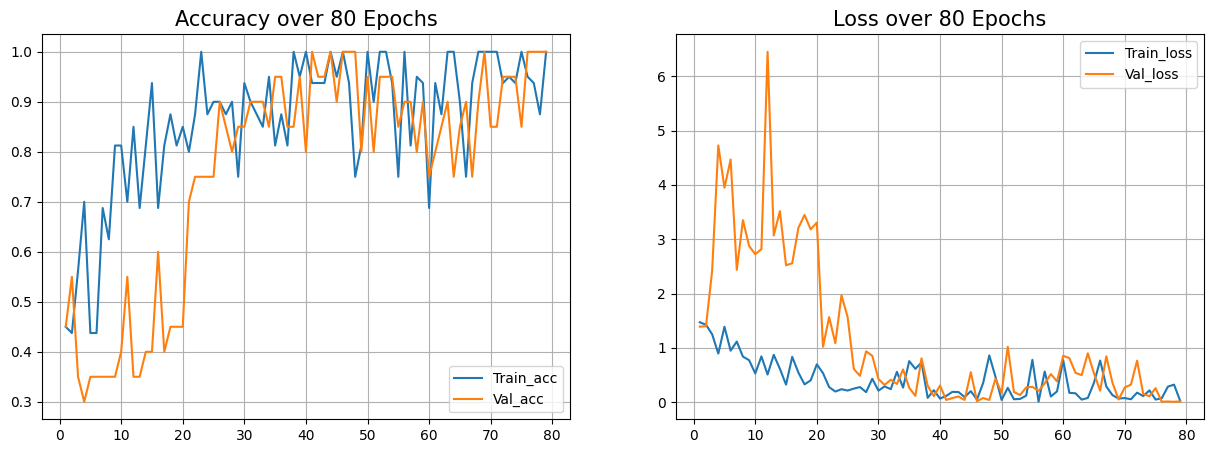

In [8]:
# Plotting akurasi dan loss dari model

import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Val_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 80)

In [9]:
# Save model

model.save('4-class-DumpTruck.h5')

c:\Users\Imam Maskuri\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
